In [26]:
import torch
import torch.nn.functional as F
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import SGD

from toss.data import DataSet, DataBunch
from toss.callbacks import BatchTransformCallback, CudaCallback, AvgStatsCallback, Recorder, ParamScheduler, LRFinder
from toss.metrics import accuracy
from toss.misc import get_mnist, normalize, mnist_resize, get_cnn_model, conv_layer, init_cnn, append_stats
from toss.train import Trainer
from toss.optimizers import Optimizer
from toss.scheduling import combine_scheds, sched_cos

In [3]:
x_train, y_train, x_valid, y_valid = get_mnist()
x_train, x_valid = normalize(x_train, x_valid)

BATCH_SIZE = 512
N_CLASSES = y_train.max() + 1
LOSS_FUNC = F.cross_entropy

train_ds = DataSet(x_train, y_train)
valid_ds = DataSet(x_valid, y_valid)

data = DataBunch(train_ds, valid_ds, batch_size=BATCH_SIZE, n_classes=N_CLASSES)

In [57]:
nfs = [8, 16, 32, 32]
# nfs = [8, 16, 32, 64, 64]
# nfs = [16, 32, 64, 64]

# sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, blr), 
#                                     sched_cos(blr, 0.2)])

cbfs = [Recorder(),
        partial(AvgStatsCallback, accuracy),
        CudaCallback(),
#         LRFinder(),
#         partial(ParamScheduler, "lr", sched),
        partial(BatchTransformCallback, mnist_resize)]

model = get_cnn_model(data, nfs, conv_layer,
                      upper_bound=6.,
                      leak=0.1, 
                      sub=0.4
                     )
init_cnn(model)
opt = SGD(model.parameters(), lr=0.9)
trainer = Trainer(model, data, LOSS_FUNC, opt=opt, cbs=cbfs)

In [58]:
with Hooks(model[:4], append_stats) as hooks:
    trainer.fit(10)

Epoch: 1
	train : [0.5194107421875, tensor(0.8452, device='cuda:0')]
	valid : [0.19091578369140624, tensor(0.9442, device='cuda:0')]
Epoch: 2
	train : [0.1796874609375, tensor(0.9455, device='cuda:0')]
	valid : [0.1169542236328125, tensor(0.9675, device='cuda:0')]
Epoch: 3
	train : [0.17610970703125, tensor(0.9488, device='cuda:0')]
	valid : [0.08982718505859374, tensor(0.9739, device='cuda:0')]
Epoch: 4
	train : [0.0767660546875, tensor(0.9770, device='cuda:0')]
	valid : [0.06850978393554688, tensor(0.9793, device='cuda:0')]
Epoch: 5
	train : [0.0568681103515625, tensor(0.9834, device='cuda:0')]
	valid : [0.06697806396484375, tensor(0.9802, device='cuda:0')]
Epoch: 6
	train : [0.0446953369140625, tensor(0.9872, device='cuda:0')]
	valid : [0.0632199951171875, tensor(0.9812, device='cuda:0')]
Epoch: 7
	train : [0.03648869140625, tensor(0.9900, device='cuda:0')]
	valid : [0.05591005859375, tensor(0.9834, device='cuda:0')]
Epoch: 8
	train : [0.03046707763671875, tensor(0.9918, device='cud

In [55]:
blr = trainer.lr_finder.best_lr
blr

0.6456542290346551

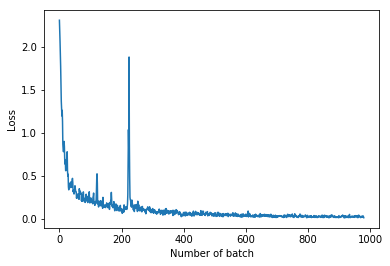

In [59]:
trainer.recorder.plot_loss()

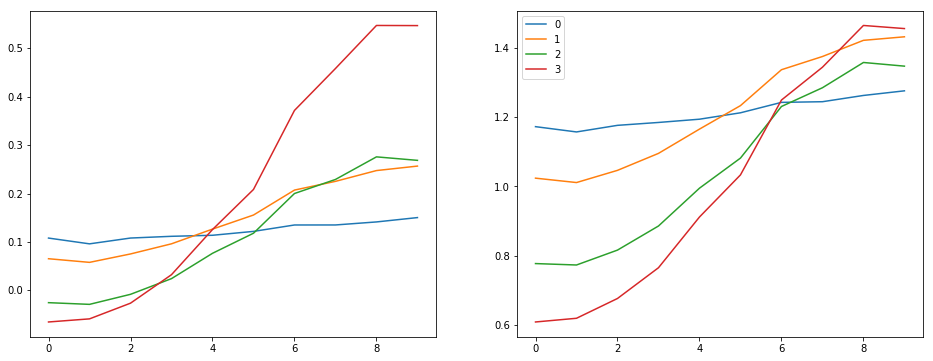

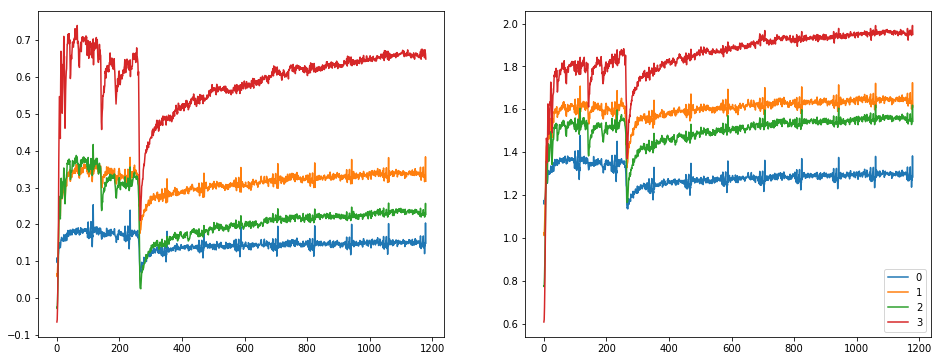

In [60]:
plot_hooks(hooks)

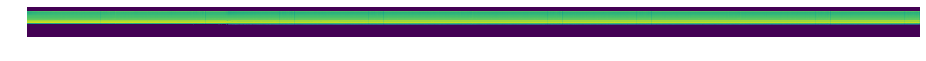

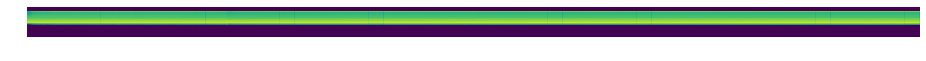

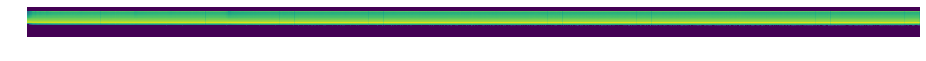

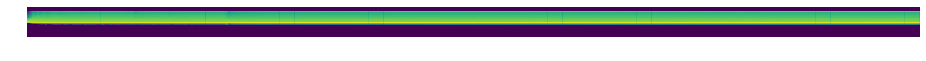

In [61]:
plot_hooks_act(hooks)

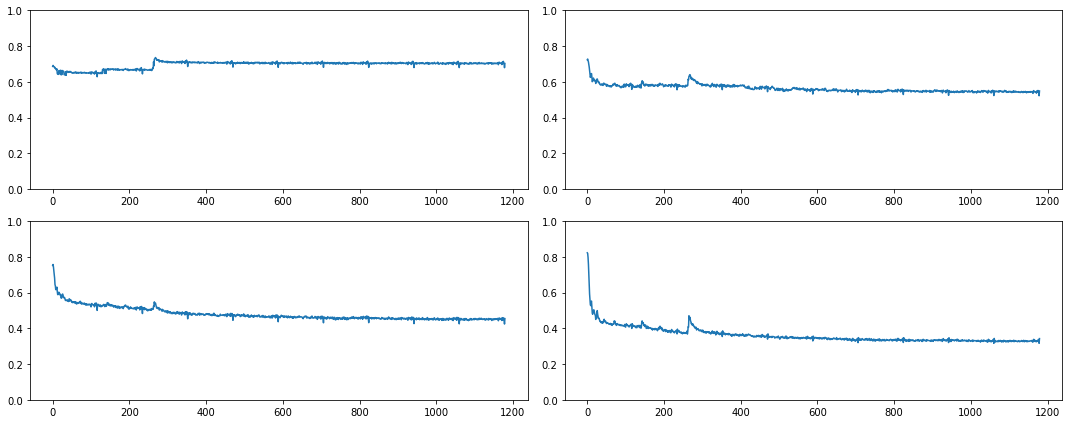

In [62]:
plot_hooks_min_act(hooks)